In [4]:
from collections import defaultdict
import itertools
import jax
import numpy as np

from benchmark import benchmark_chains
import blackjax
from blackjax.mcmc.mhmclmc import rescale
from blackjax.util import run_inference_algorithm
import jax.numpy as jnp 

from inference_models import models

def sampler_mhmclmc(step_size, num_steps_per_traj):

    def s(logdensity_fn, num_steps, initial_position, key):

        alg = blackjax.mcmc.mhmclmc.mhmclmc(
        logdensity_fn=logdensity_fn,
        step_size=step_size,
        integration_steps_fn = lambda key: jnp.round(jax.random.uniform(key) * rescale(num_steps_per_traj + 0.5)) ,
        # integration_steps_fn = lambda _ : 5,
        # integration_steps_fn = lambda key: jnp.ceil(jax.random.poisson(key, L/step_size )) ,

        )
        
        _, out, info = run_inference_algorithm(
        rng_key=key,
        initial_state_or_position=initial_position,
        inference_algorithm=alg,
        num_steps=num_steps, 
        transform=lambda x: x.position, 
        progress_bar=True)

        # print(info.acceptance_rate.mean(), "acceptance probability")
        # print(out.var(axis=0), "acceptance probability")

        return out, num_steps_per_traj

    return s

results = defaultdict(float)

for model in ["Banana"]:
    # for sampler in ["mclmc"]:
    for sampler in itertools.product(np.linspace(1e-2, 1e0, 10), np.linspace(5, 10, 2)):
        # result = benchmark(models[model], samplers[sampler])
        # result = benchmark_chains(models[model], samplers[sampler])
        result = benchmark_chains(models[model], sampler_mhmclmc(*sampler), n=10000)
        # print(result, result2, "results")
        results[(model, sampler)] = result


crossing 10000


12


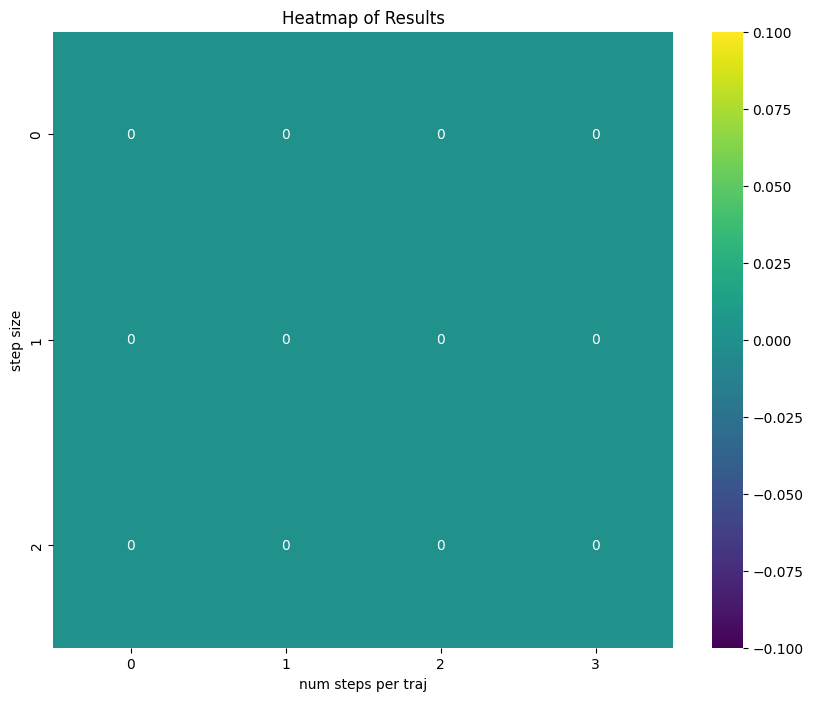

In [2]:
import seaborn as sns

import matplotlib.pyplot as plt

# Extract x and y values from the keys of the results dictionary
x_values = [key[0] for key in results.keys()]
y_values = [key[1] for key in results.keys()]

print(len(x_values))
# raise Exception

# Extract heat values from the dictionary
heat_values = list(results.values())


# Reshape the heat values into a 2D array
# heat_array = np.array(heat_values).reshape((len(x_values), len(y_values)))
heat_array = np.array(heat_values).reshape((3,4))

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heat_array, annot=True, cmap='viridis')
plt.xlabel('num steps per traj')
plt.ylabel('step size')
plt.title('Heatmap of Results')
plt.show()


In [10]:
results

defaultdict(float,
            {('simple', (10.0, 1.0)): Array(0.18656716, dtype=float32),
             ('simple',
              (10.0, 1.4444444444444444)): Array(0.25452492, dtype=float32),
             ('simple',
              (10.0, 1.8888888888888888)): Array(0.24509802, dtype=float32),
             ('simple',
              (10.0, 2.333333333333333)): Array(0.17281109, dtype=float32),
             ('simple',
              (10.0, 2.7777777777777777)): Array(0.17999998, dtype=float32),
             ('simple',
              (10.0, 3.2222222222222223)): Array(0.14502098, dtype=float32),
             ('simple',
              (10.0, 3.6666666666666665)): Array(0.15321758, dtype=float32),
             ('simple',
              (10.0, 4.111111111111111)): Array(0.1253831, dtype=float32),
             ('simple',
              (10.0, 4.555555555555555)): Array(0.11315059, dtype=float32),
             ('simple', (10.0, 5.0)): Array(0.11111111, dtype=float32),
             ('simple',
         